In [16]:
## convert bees data to format for trex detect-tracking
beedir = '/Users/jacob/Desktop/beesbook2025/example_videos_KN/'
df = pd.read_parquet(beedir+'cam-1_20251003T120750.71761.648Z--20251003T120849.991274.118Z-detections.parquet')
df = df[~(df['detection_type']=='TaggedBee')]
df = df[['frameIdx','xpos','ypos']]
df = df.rename(columns={'frameIdx':'frame', 'xpos':'x', 'ypos':'y'})
df.to_csv(beedir+'frame-x-y.csv',index=False)

# Behavior embedding + clustering workflow (v2)


Next improvements and things to add:
- visualization of behavior labels, along with tracks (bounding box or color, in area that occurs)
- parameters with inputset, keeping things consistent:  if a name has e.g. v1, multiple different configurations could actually go there (e.g. wavelets with 25 freqs, and with 5 freqs).  is there a more consistent way to keep track of or check this, or is this ok?
- more input features:  VASSI - what do they use?  can Movement be used for more input features?
- more behavioral models:  survey of existing ones


In [2]:
import importlib
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd
import subprocess
import json

from behavior import dataset as ds
import behavior.features as features      # entire features module
import behavior.analysis as analysis      # if you move analysis.py under src, or

importlib.reload(ds)
importlib.reload(features)
importlib.reload(analysis)


<module 'behavior.analysis' from '/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/analysis.py'>

## Dataset & pipeline configuration


In [26]:
DATASET_CONFIGS = {
    "calms21": {
        "manifest": "/Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml",
        "manifest_params": {
            "name": "calms21",
            "base_dir": "/Volumes/JD-SSD/mice_data/calms21/dataset/",
            "version": "0.1.0",
            "index_format": "group/sequence",
        },
        "groups": ["calms21_task1_train","calms21_task1_test"],
        "media_index": {
            "search_dirs": ["/Volumes/JD-SSD/mice_data/calms21/task1_videos_mp4/"],
            "extensions": (".mp4", ".avi"),
        },
        "tracks_index": {
            "search_dirs": ["/Volumes/JD-SSD/mice_data/calms21/data"],
            "patterns": "calms*.npy",
            "src_format": "calms21_npy",
            "multi_sequences_per_file": True,
            "group_from": "filename",
        },
        "convert_tracks": {
            "params": {"neck_idx": None, "tail_idx": None},
            "overwrite": False,
            "group_from": "filename",
        },
        "convert_labels_kind": "behavior",
        "pose_distance_params": {"n_components": 6, "pose_n": 7},
        "egocentric_params": {"neck_idx": 3, "tail_base_idx": 6},
        "wavelet_params": {
            "fps_default": 30.0,
            "f_min": 0.2,
            "f_max": 5.0,
            "n_freq": 25,
            "wavelet": "cmor1.5-1.0",
            "log_floor": -3.0,
        },
        "tsne_params": {"total_templates": 2000, "perplexity": 50, "n_jobs": 8},
        "kmeans_ks": [50, 100, 150],
        "ward_cuts": [20],
        "label_kind": "behavior",
        "analysis_max_frames": 300_000,
    },
    "esi11-11": {
        "manifest": "/Volumes/JD-SSD/ESI-mice/dataset1/dataset.yaml",
        "manifest_params": {
            "name": "esi11-11",
            "base_dir": "/Volumes/JD-SSD/ESI-mice/dataset1/",
            "version": "0.1.0",
            "index_format": "group/sequence",
        },
        "groups": None,
        "media_index": {
            "search_dirs": ["/Volumes/JD-SSD/ESI-mice/"],
            "extensions": [".mp4"],
        },
        "tracks_index": {
            "search_dirs": ["/Volumes/JD-SSD/ESI-mice/data"],
            "patterns": "*.npz",
            "src_format": "trex_npz",
            "multi_sequences_per_file": False,
        },
        "convert_tracks": {
            "merge_per_sequence": True,
        },
        "convert_labels_kind": None,
        "pose_distance_params": {"n_components": 6, "pose_n": 7},
        "egocentric_params": {"neck_idx": 3, "tail_base_idx": 6},
        "wavelet_params": {
            "fps_default": 30.0,
            "f_min": 0.2,
            "f_max": 5.0,
            "n_freq": 25,
            "wavelet": "cmor1.5-1.0",
            "log_floor": -3.0,
        },
        "tsne_params": {"total_templates": 2000, "perplexity": 50, "n_jobs": 8},
        "kmeans_ks": [50, 100],
        "ward_cuts": [20],
        "label_kind": "behavior",
        "analysis_max_frames": 300_000,
    },
}

ACTIVE_DATASET = "esi11-11"  # calms21, esi11-11
CFG = DATASET_CONFIGS[ACTIVE_DATASET]
GROUP_SCOPE = CFG.get("groups")
LABEL_KIND = CFG.get("label_kind")
print(f"Using dataset '{ACTIVE_DATASET}'")


Using dataset 'esi11-11'


## Load / create dataset manifest


In [27]:
manifest_path = Path(CFG["manifest"])
if not manifest_path.exists():
    manifest_args = CFG.get("manifest_params")
    if not manifest_args:
        raise FileNotFoundError(f"Manifest {manifest_path} is missing and no creation params were provided.")
    created = ds.new_dataset_manifest(**manifest_args)
    print(f"Created manifest at {created}")

dataset = ds.Dataset(str(manifest_path))
dataset.load()
print(f"Loaded dataset '{dataset.name}' -> {manifest_path}")
print("Group scope:", GROUP_SCOPE or "<all groups>")


Loaded dataset 'esi11-11' -> /Volumes/JD-SSD/ESI-mice/dataset1/dataset.yaml
Group scope: <all groups>


## Index raw media / tracks (optional)


In [50]:
if CFG.get("media_index"):
    dataset.index_media(**CFG["media_index"])

if CFG.get("tracks_index"):
    dataset.index_tracks_raw(**CFG["tracks_index"])

if CFG.get("convert_tracks"):
    dataset.convert_all_tracks(**CFG["convert_tracks"])

if CFG.get("convert_labels_kind"):
    dataset.convert_all_labels(kind=CFG["convert_labels_kind"])


[index_media] ffprobe failed for /Volumes/JD-SSD/ESI-mice/._sub-all_strain-B6_2024-12-02T10_50_55.mp4: Command '['ffprobe', '-v', 'error', '-select_streams', 'v:0', '-show_entries', 'stream=width,height,avg_frame_rate,r_frame_rate,codec_name', '-of', 'json', '/Volumes/JD-SSD/ESI-mice/._sub-all_strain-B6_2024-12-02T10_50_55.mp4']' returned non-zero exit status 1.
[index_media] ffprobe failed for /Volumes/JD-SSD/ESI-mice/._sub-all_strain-B6_2024-11-11T15_30_06.mp4: Command '['ffprobe', '-v', 'error', '-select_streams', 'v:0', '-show_entries', 'stream=width,height,avg_frame_rate,r_frame_rate,codec_name', '-of', 'json', '/Volumes/JD-SSD/ESI-mice/._sub-all_strain-B6_2024-11-11T15_30_06.mp4']' returned non-zero exit status 1.
[index_media] ffprobe failed for /Volumes/JD-SSD/ESI-mice/._sub-all_strain-B6_2024-12-02T12_30_05.mp4: Command '['ffprobe', '-v', 'error', '-select_streams', 'v:0', '-show_entries', 'stream=width,height,avg_frame_rate,r_frame_rate,codec_name', '-of', 'json', '/Volumes/J

[index_media] Wrote 179 entries -> /Volumes/JD-SSD/ESI-mice/dataset1/media/index.csv
[index_tracks_raw] 4 -> /Volumes/JD-SSD/ESI-mice/dataset1/tracks_raw/index.csv


## Pair pose-distance + social wavelet


In [13]:
pose_params = dict(CFG.get("pose_distance_params", {"n_components": 6, "pose_n": 7}))
feat_pose = features.PairPoseDistancePCA(params=pose_params)
pose_run = dataset.run_feature(feat_pose, groups=GROUP_SCOPE)
print("pair-posedistance-pca run:", pose_run)

wavelet_params = dict(CFG.get("wavelet_params", {}))
feat_wave_social = features.PairWavelet(params=wavelet_params)
social_wave_run = dataset.run_feature(
    feat_wave_social,
    input_kind="feature",
    input_feature="pair-posedistance-pca",
    input_run_id=pose_run,
    groups=GROUP_SCOPE,
)
print("pair-wavelet (social) run:", social_wave_run)


[feature:pair-posedistance-pca] completed run_id=0.1-d2cdb45ffd -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-pca/0.1-d2cdb45ffd
pair-posedistance-pca run: 0.1-d2cdb45ffd
[feature:pair-wavelet__from__pair-posedistance-pca] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-posedistance-pca/0.1-88d79630c2
pair-wavelet (social) run: 0.1-88d79630c2


## Pair egocentric + ego wavelet


In [14]:
egocentric_params = dict(CFG.get("egocentric_params", {"neck_idx": 3, "tail_base_idx": 6}))
feat_ego = features.PairEgocentricFeatures(params=egocentric_params)
ego_run = dataset.run_feature(feat_ego, groups=GROUP_SCOPE)
print("pair-egocentric run:", ego_run)

wavelet_params = dict(CFG.get("wavelet_params", {}))
feat_wave_ego = features.PairWavelet(params=wavelet_params)
ego_wave_run = dataset.run_feature(
    feat_wave_ego,
    input_kind="feature",
    input_feature="pair-egocentric",
    input_run_id=ego_run,
    groups=GROUP_SCOPE,
)
print("pair-wavelet (ego) run:", ego_wave_run)


[feature:pair-egocentric] completed run_id=0.1-5f7ddf53ba -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-egocentric/0.1-5f7ddf53ba
pair-egocentric run: 0.1-5f7ddf53ba
[feature:pair-wavelet__from__pair-egocentric] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-egocentric/0.1-88d79630c2
pair-wavelet (ego) run: 0.1-88d79630c2


## Inputset for social + ego features


In [8]:
INPUTSET_NAME = 'social+ego'
inputset_inputs = [
        {
            "feature": "pair-wavelet__from__pair-posedistance-pca",
            "run_id": None,
            "pattern": "*.parquet",
            "load": {"kind": "parquet", "transpose": False},
        },
        {
            "feature": "pair-wavelet__from__pair-egocentric",
            "run_id": None,
            "pattern": "*.parquet",
            "load": {"kind": "parquet", "transpose": False},
        },
    ]
features.save_inputset(dataset, INPUTSET_NAME, inputset_inputs, overwrite=True)

PosixPath('/Volumes/JD-SSD/mice_data/calms21/dataset/inputsets/social%2Bego.json')

## Global t-SNE embedding


In [10]:
tsne_params = dict(CFG.get("tsne_params", {}))
tsne_params["inputset"] = INPUTSET_NAME
feat_tsne = features.GlobalTSNE(params=tsne_params)
tsne_run = dataset.run_feature(
    feat_tsne,
    input_kind="inputset",
    input_feature=INPUTSET_NAME,
    groups=GROUP_SCOPE,
)
tsne_feature = f"{feat_tsne.name}__from__{INPUTSET_NAME}"
print("tsne feature:", tsne_feature)


[feature:global-tsne__from__social+ego] completed run_id=0.2-3eb0cff127 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-tsne__from__social+ego/0.2-3eb0cff127
tsne feature: global-tsne__from__social+ego


In [25]:
tsne_run = '0.2-3eb0cff127'

## Global K-Means sweeps


In [11]:
tsne_artifact_spec = {
    "feature": tsne_feature,
    "run_id": None,
    "pattern": "global_templates_features.npz",
    "load": {"kind": "npz", "key": "templates"},
}
tsne_scaler_spec = {
    "feature": tsne_feature,
    "run_id": None,
    "pattern": "global_opentsne_embedding.joblib",
    "key": "scaler",
}

kmeans_runs = []
for k in [10,20,40,80,100]:
    feat_kmeans = features.GlobalKMeansClustering(params={
        "k": int(k),
        "artifact": dict(tsne_artifact_spec),
        "label_artifact_points": True,
        "assign": {
            "scaler": dict(tsne_scaler_spec),
            "inputset": INPUTSET_NAME,
        },
    })
    k_run = dataset.run_feature(
        feat_kmeans,
        input_kind="feature",
        input_feature=tsne_feature,
        groups=GROUP_SCOPE,
    )
    kmeans_runs.append({"k": int(k), "run_id": k_run})
    print(f"k-means k={k} -> {k_run}")

kmeans_feature = f"global-kmeans__from__{tsne_feature}"


[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-50a6f3447e -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-50a6f3447e
k-means k=10 -> 0.3-50a6f3447e
[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-36c1a5b388 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-36c1a5b388
k-means k=20 -> 0.3-36c1a5b388
[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-b47a7812c3 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-b47a7812c3
k-means k=40 -> 0.3-b47a7812c3
[feature:global-kmeans__from__global-tsne__from__social+ego] completed run_id=0.3-6ec17b7293 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego/0.3-6ec17b7293
k-means k=80 -> 0.3-6ec17b7293
[feature:global-kmeans__

## Ward clustering + per-frame assignments


In [74]:
CFG.get("ward_cuts")

[20]

In [12]:
feat_ward = features.GlobalWardClustering(params={
    "artifact": dict(tsne_artifact_spec),
})
ward_run = dataset.run_feature(
    feat_ward,
    input_kind="feature",
    input_feature=tsne_feature,
    groups=GROUP_SCOPE,
)
print("ward run:", ward_run)

ward_feature = f"global-ward__from__{tsne_feature}"
ward_assign_runs = []
for cut in [10, 20, 40, 60, 80]:
    assign = features.WardAssignClustering(params={
        "ward_model": {
            "feature": ward_feature,
            "run_id": ward_run,
            "pattern": "model.joblib",
        },
        "artifact": dict(tsne_artifact_spec),
        "scaler": dict(tsne_scaler_spec),
        "inputset": INPUTSET_NAME,
        "n_clusters": int(cut),
        "recalc": False,
    })
    assign_run = dataset.run_feature(
        assign,
        input_kind="inputset",
        input_feature=INPUTSET_NAME,
        groups=GROUP_SCOPE,
    )
    ward_assign_runs.append({"n_clusters": int(cut), "run_id": assign_run})
    print(f"ward-assign k={cut} -> {assign_run}")

ward_assign_feature = f"ward-assign__from__{ward_feature}"
last_ward_assign_run = ward_assign_runs[-1]["run_id"] if ward_assign_runs else None


[feature:global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-2912298eef -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-ward__from__global-tsne__from__social+ego/0.1-2912298eef
ward run: 0.1-2912298eef
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-a80d0ad0b1 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__global-tsne__from__social+ego/0.1-a80d0ad0b1
ward-assign k=10 -> 0.1-a80d0ad0b1
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-e342f8e942 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__global-tsne__from__social+ego/0.1-e342f8e942
ward-assign k=20 -> 0.1-e342f8e942
[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego] completed run_id=0.1-c7db479be4 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__

## Cached run summaries


In [21]:
try:
    kmeans_summary = analysis.list_feature_runs(dataset, kmeans_feature)
except FileNotFoundError:
    kmeans_summary = pd.DataFrame()

try:
    ward_summary = analysis.list_feature_runs(dataset, ward_assign_feature)
except FileNotFoundError:
    ward_summary = pd.DataFrame()

if not kmeans_summary.empty:
    display(kmeans_summary[[c for c in ["run_id", "k", "finished_at", "model_path"] if c in kmeans_summary.columns]])
else:
    print("No k-means runs discovered yet.")

if not ward_summary.empty:
    display(ward_summary[[c for c in ["run_id", "n_clusters", "finished_at", "model_path"] if c in ward_summary.columns]])
else:
    print("No ward-assign runs discovered yet.")


,run_id,k,finished_at,model_path
0,0.3-8bcaef5273,100,2025-12-08T11:20:02.538850+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
1,0.3-6ec17b7293,80,2025-12-08T11:19:54.769727+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
2,0.3-b47a7812c3,40,2025-12-08T11:19:47.147877+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
3,0.3-36c1a5b388,20,2025-12-08T11:19:39.782498+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
4,0.3-50a6f3447e,10,2025-12-08T11:19:32.557224+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...


,run_id,n_clusters,finished_at,model_path
0,0.1-bb8b0064fe,80,2025-12-08T11:23:57.350965+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
1,0.1-ab579a6724,60,2025-12-08T11:23:09.825032+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
2,0.1-c7db479be4,40,2025-12-08T11:22:22.255578+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
3,0.1-e342f8e942,20,2025-12-08T11:21:34.941348+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...
4,0.1-a80d0ad0b1,10,2025-12-08T11:20:47.661642+00:00,/Volumes/JD-SSD/mice_data/calms21/dataset/feat...


## Quantitative cluster ⇄ label agreement


In [5]:
if not LABEL_KIND:
    print("No label_kind configured; skipping agreement metrics.")
else:
    kmeans_metrics = []
    if 'kmeans_summary' in globals() and not kmeans_summary.empty:
        for _, row in kmeans_summary.iterrows():
            metrics = analysis.compute_cluster_label_agreement(
                dataset,
                cluster_feature=kmeans_feature,
                cluster_run_id=row["run_id"],
                label_kind=LABEL_KIND,
                max_frames=CFG.get("analysis_max_frames"),
                include_per_sequence=False,
            )
            kmeans_metrics.append({
                "k": row.get("k"),
                "run_id": row["run_id"],
                "ARI": metrics["metrics"]["ARI"],
                "AMI": metrics["metrics"]["AMI"],
                "purity": metrics["metrics"]["purity"],
                "hungarian_accuracy": metrics["metrics"]["hungarian_accuracy"],
            })
        if kmeans_metrics:
            display(pd.DataFrame(kmeans_metrics).sort_values(by="ARI", ascending=False))

    ward_metrics = []
    if 'ward_summary' in globals() and not ward_summary.empty:
        for _, row in ward_summary.iterrows():
            metrics = analysis.compute_cluster_label_agreement(
                dataset,
                cluster_feature=ward_assign_feature,
                cluster_run_id=row["run_id"],
                label_kind=LABEL_KIND,
                max_frames=CFG.get("analysis_max_frames"),
                include_per_sequence=False,
            )
            ward_metrics.append({
                "n_clusters": row.get("n_clusters"),
                "run_id": row["run_id"],
                "ARI": metrics["metrics"]["ARI"],
                "AMI": metrics["metrics"]["AMI"],
                "purity": metrics["metrics"]["purity"],
                "hungarian_accuracy": metrics["metrics"]["hungarian_accuracy"],
            })
        if ward_metrics:
            display(pd.DataFrame(ward_metrics).sort_values(by="ARI", ascending=False))


## Visualization helper


### Ward

In [26]:
from pathlib import Path
import joblib
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# point to your ward run
ward_feature = "global-ward__from__global-tsne__from__social+ego"
ward_run_id  = ward_run

run_root = dataset.get_root("features") / ward_feature / ward_run_id
model_path = run_root / "model.joblib"    # or run_root / "model.npz" if you prefer

# load linkage
bundle = joblib.load(model_path)
Z = bundle["linkage_matrix"]  # shape (n-1, 4)

plt.figure(figsize=(5, 5))
dendrogram(Z, no_labels=True, color_threshold=100, truncate_mode='level', p=6)
plt.title(f"Ward dendrogram: {ward_feature} ({ward_run_id})")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


NameError: name 'ward_run' is not defined

In [27]:
wardruns = ward_summary[['n_clusters','run_id']].set_index('n_clusters')
print(wardruns)

                    run_id
n_clusters                
80          0.1-bb8b0064fe
60          0.1-ab579a6724
40          0.1-c7db479be4
20          0.1-e342f8e942
10          0.1-a80d0ad0b1


[feature:viz-global-colored__from__global-tsne__from__social+ego] completed run_id=0.1-45e1578eb0 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego/0.1-45e1578eb0
viz run: 0.1-45e1578eb0


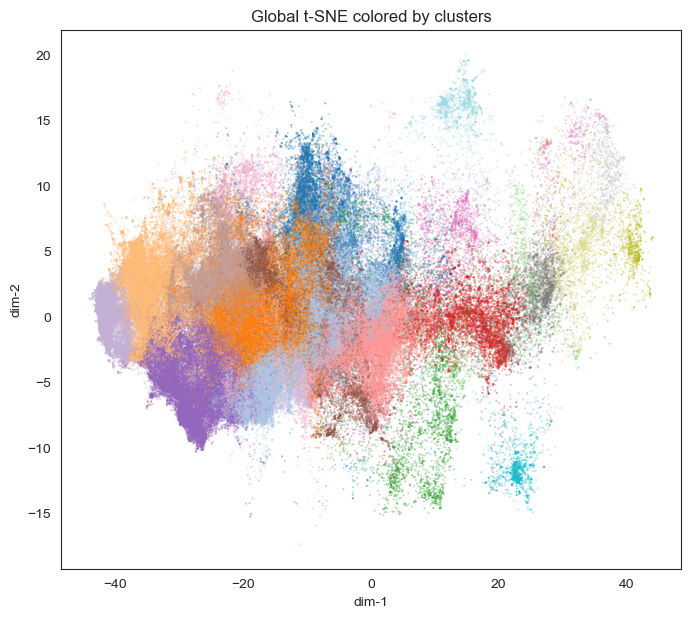

In [28]:
viz_labels_feature = ward_assign_feature  # swap to k-means feature if desired
viz_labels_run = wardruns.loc[20].values[0]

# viz_labels_feature = kmeans_feature
# viz_labels_run = kmeansruns.loc[20].values[0]

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": tsne_feature,
        "run_id": tsne_run,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": viz_labels_feature,
        "run_id": viz_labels_run,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": None,
    "title": "Global t-SNE colored by clusters",
})

viz_run = dataset.run_feature(viz, input_kind="feature", input_feature=tsne_feature)
print("viz run:", viz_run)


### kmeans

In [29]:
kmeansruns = kmeans_summary[['k','run_id']].set_index('k')
print(kmeansruns)

             run_id
k                  
100  0.3-8bcaef5273
80   0.3-6ec17b7293
40   0.3-b47a7812c3
20   0.3-36c1a5b388
10   0.3-50a6f3447e


[feature:viz-global-colored__from__global-tsne__from__social+ego] completed run_id=0.1-7216576d25 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego/0.1-7216576d25
viz run: 0.1-7216576d25


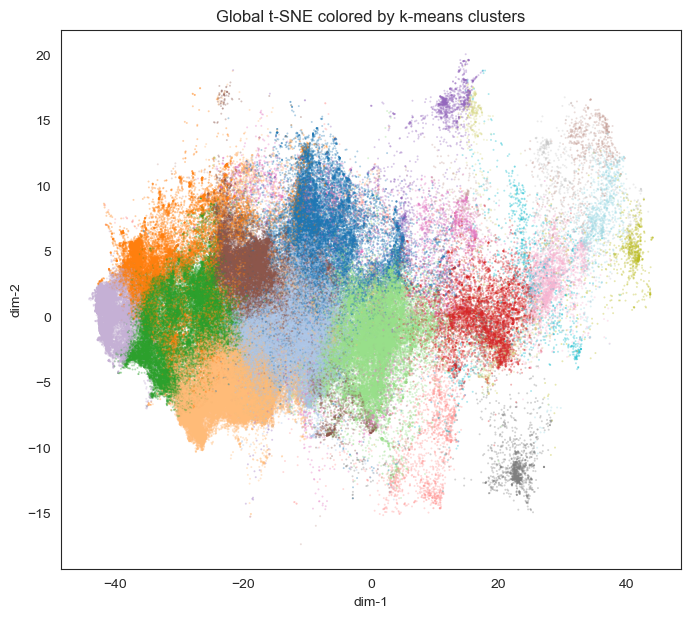

In [33]:
importlib.reload(features)


viz_labels_feature = kmeans_feature                 # e.g. "global-kmeans__from__global-tsne__from__social+ego@v1"
viz_labels_run = kmeansruns.loc[20].values[0]       # pick your run_id

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": tsne_feature,
        "run_id": tsne_run,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": viz_labels_feature,
        "run_id": viz_labels_run,
        "pattern": "global_kmeans_labels_seq=*.npz",
        "load": {"kind": "npz", "key": "labels"},   # labels key in the npz
    },
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": r"seq=(.+?)$",               # extracts <safe_seq> from the labels filename
    "title": "Global t-SNE colored by k-means clusters",
})

viz_run = dataset.run_feature(viz, input_kind="feature", input_feature=tsne_feature, 
                             groups=GROUP_SCOPE,
                              sequences=dataset.list_sequences()[0:2])
print("viz run:", viz_run)


### Ground Truth

[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse071_task1_annotator1 (23810 vs 47620); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse072_task1_annotator1 (18164 vs 36328); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse073_task1_annotator1 (19156 vs 38312); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse074_task1_annotator1 (18825 vs 37650); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorter than coords for key=task1%2Ftest%2Fmouse075_task1_annotator1 (18015 vs 36030); repeating labels x2 (likely per-id/perspective duplication in inputs).
[viz-global-colored] INFO: labels shorte

[feature:viz-global-colored__from__global-tsne__from__social+ego] completed run_id=0.1-87316d06e4 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego/0.1-87316d06e4
viz run: 0.1-87316d06e4


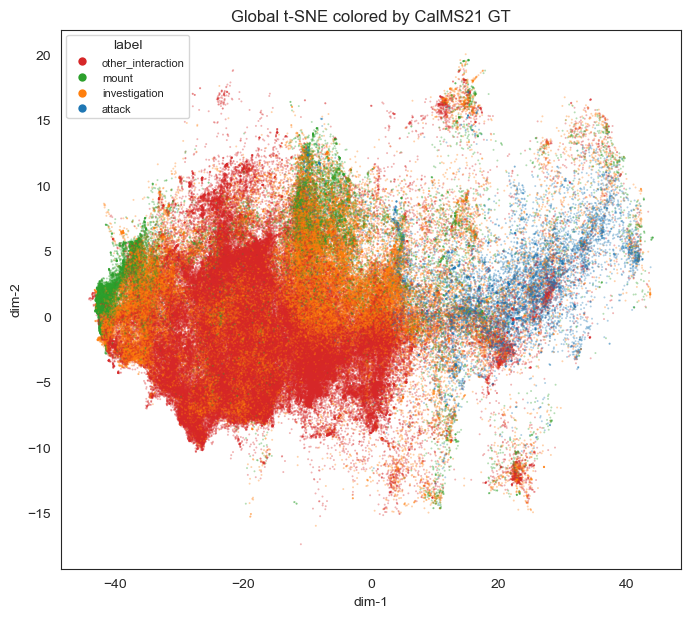

In [156]:
import importlib, seaborn as sns
from behavior import features
from behavior.dataset import BEHAVIOR_LABEL_MAP
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {"feature": tsne_feature, "run_id": tsne_run,
               "pattern": "global_tsne_coords_seq=*.npz", "load": {"kind": "npz", "key": "Y"}},
    "labels": {"source": "labels", "kind": "behavior", "load": {"kind": "npz", "key": "labels"}},
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": r"seq=(.+?)$",
    "title": "Global t-SNE colored by CalMS21 GT",
    "label_order": list(BEHAVIOR_LABEL_MAP.keys()),
    "label_name_map": BEHAVIOR_LABEL_MAP,           # <-- names in legend
    "palette": sns.color_palette("tab10", len(BEHAVIOR_LABEL_MAP)),
})

viz_run = dataset.run_feature(
    viz,
    input_kind="feature",
    input_feature=tsne_feature,
    groups=GROUP_SCOPE,
    # sequences=dataset.list_sequences()[0:1],
    overwrite=True,
)
print("viz run:", viz_run)


/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


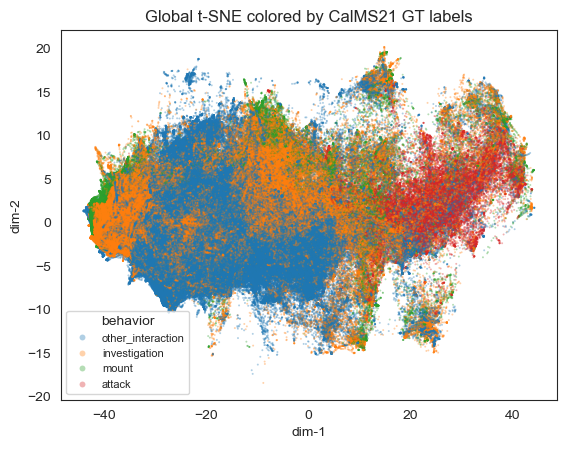

In [155]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from behavior.dataset import BEHAVIOR_LABEL_MAP
from behavior.helpers import to_safe_name

allowed_groups = set(GROUP_SCOPE)
allowed_safe_groups = {to_safe_name(g) for g in allowed_groups}

# t-SNE coords
tsne_root = dataset.get_root("features") / tsne_feature / tsne_run
coord_files = sorted(tsne_root.glob("global_tsne_coords_seq=*.npz"))

# CalMS21 GT labels
labels_idx = dataset.get_root("labels") / "behavior" / "index.csv"
df_labels = pd.read_csv(labels_idx)
# keep only groups in scope
df_labels = df_labels[df_labels["group"].isin(allowed_groups) | df_labels["group_safe"].isin(allowed_safe_groups)]
label_path_for_seq = {row.sequence_safe: Path(row.abs_path) for row in df_labels.itertuples()}

Y_all, L_all = [], []
for fp in coord_files:
    # print(coord_files)
    m = re.search(r"seq=(.+?)(?:_persp=.*)?$", fp.stem)
    if not m:
        continue
    safe_seq = m.group(1)
    lp = label_path_for_seq.get(safe_seq)
    if lp is None or not lp.exists():
        continue
    Y = np.load(fp)["Y"]
    L = np.load(lp)["labels"]
    n = min(len(Y), len(L)) * n
    L = np.concatenate([L,L] )
    if n == 0:
        continue
    Y_all.append(Y)
    L_all.append(L)
    # break

if not Y_all:
    raise RuntimeError("No coords/labels after filtering to GROUP_SCOPE.")

Y_all = np.vstack(Y_all)
L_all = np.concatenate(L_all)

label_names = {i: name for i, name in BEHAVIOR_LABEL_MAP.items()}
palette = sns.color_palette("tab10", len(label_names))
sns.scatterplot(
    x=Y_all[:, 0], y=Y_all[:, 1],
    hue=pd.Series(L_all).map(label_names),
    palette=palette, s=2, alpha=0.35, linewidth=0, legend="full",
)
plt.title("Global t-SNE colored by CalMS21 GT labels")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.legend(title="behavior", markerscale=3, fontsize=8)
plt.show()


# ESI dataset -  use tsne embedding from CALMS

In [28]:
feat_tsne_map = features.GlobalTSNE(params={
    "inputset": "social+ego",
    "map_existing_inputs": True,
    "reuse_embedding": {
        "feature": "calms-global-tsne",
        "run_id": None,  # latest CALMS run
        "pattern": "global_opentsne_embedding.joblib",
    },
    # optional if you want templates copied over:
    # "artifact": {
    #     "feature": "calms-global-tsne",
    #     "pattern": "global_templates_features.npz",
    #     "load": {"kind": "npz", "key": "templates"},
    # },
})
esi_tsne_run = dataset.run_feature(
    feat_tsne_map,
    input_kind="inputset",
    input_feature="social+ego",
)


[feature:global-tsne__from__social+ego] completed run_id=0.2-7e204e2734 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-tsne__from__social+ego/0.2-7e204e2734


In [29]:
## assign cluster labels
ward_assign = features.WardAssignClustering(params={
    "ward_model": {
        "feature": "global-ward__from__global-tsne",
        "run_id": None,
        "pattern": "model.joblib",
    },
    "artifact": {  # still uses the TSNE templates/scaler space
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "scaler": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_opentsne_embedding.joblib",
        "key": "scaler",
    },
    "inputset": "social+ego@v1",   # reuse the preset you saved earlier
    "n_clusters": 10,
    "recalc": False,
})

ward_assign_run = dataset.run_feature(
    ward_assign,
    input_kind="inputset",
    input_feature="social+ego",   # tells the runner which inputset drives scope/streaming
)
print("ward-assign run:", ward_assign_run)

[feature:ward-assign__from__global-ward__from__global-tsne] completed run_id=0.1-2800a6d0c4 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/ward-assign__from__global-ward__from__global-tsne/0.1-2800a6d0c4
ward-assign run: 0.1-2800a6d0c4


[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-66532354e8 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-66532354e8
viz run: 0.1-66532354e8


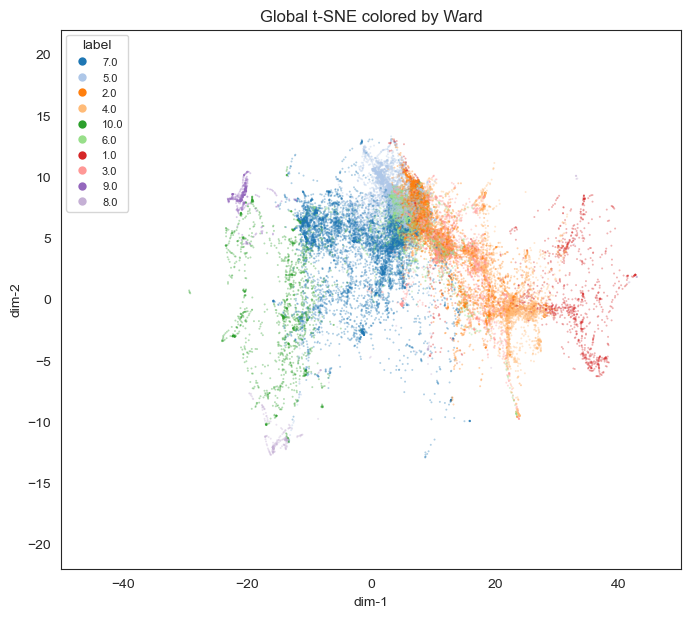

In [31]:
# esi_globaltsne = "0.2-419d3315f8"
esi_calms_globaltsne = None
coords_run = esi_calms_globaltsne

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne__from__social+ego@v1",
        "run_id": coords_run,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "ward-assign__from__global-ward__from__global-tsne",
        "run_id": None,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+)",
    "label_key_regex": r"seq=(.+)",
    "title": "Global t-SNE colored by Ward",
})

viz_run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")
plt.ylim(-22,22)
plt.xlim(-50,50)
print("viz run:", viz_run_id)


# Model Training

In [19]:
remote_cfg_03 = {
    "local_root": "/Volumes/JD-SSD/mice_data/calms21/dataset",
    "remote_root": "/home/jdavidson/mice_data/calms21/dataset",
    "root_map": {
        "/Volumes/JD-SSD/mice_data": "/home/jdavidson/mice_data"
    },
    "ssh_host": "jdavidson@100.77.35.28",
    "jupyter_url": "http://100.77.35.28:8888/lab?token=974853ff7c859db1b24198731bcb288c57bdbe9accbedcee",  # optional
    "python_cmd": "/home/jdavidson/miniforge3/envs/ecodylic/bin/python",
    "rsync_opts": ["--exclude", "media/", "--exclude", "*.mp4", 
                   "--exclude", "*.py", "--exclude", "*.ipynb", 
                   "--exclude", "features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1"],
    "rsync_progress": False
}

remote_cfg = remote_cfg_03

In [20]:
dataset.sync_to_remote(remote_cfg)

[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:to] running: rsync -az --delete --exclude .remote_jobs/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 /Volumes/JD-SSD/mice_data/calms21/dataset/ jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/


In [22]:
dataset.sync_from_remote(remote_cfg, include=["models/**"])

[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:from] running: rsync -az --delete --include models/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/ /Volumes/JD-SSD/mice_data/calms21/dataset/


## TemporalStacking of features for model input

In [ ]:
stack_params = {
    "inputset": "social+ego",
    "half": 2,
    "skip": 1,
    "use_temporal_stack": True,
    "sigma_stack": 1,
    "add_pool": False,
    "pool_stats": ("mean",),
    "sigma_pool": 1,
    "stack_chunk_size": 1000,   # optional
}

In [10]:
importlib.reload(features)

# sync the package files needed
import subprocess
# cmd = "rsync * jdavidson@kn-cgpu03:/home/jdavidson/mice_data/calms21/dataset/."

cmd = "rsync -av \
    --exclude='*.pyc' --exclude='__pycache__' \
    /Users/jacob/Documents/GitHub/EcodylicScience/behavior \
    " + remote_cfg['ssh_host'] + ":/home/jdavidson/"
subprocess.run(cmd, shell=True, check=True)



Transfer starting: 510 files
behavior/
behavior/.DS_Store
behavior/behavior-v3.ipynb
behavior/.git/
behavior/.git/.DS_Store
behavior/src/
behavior/src/.DS_Store

sent 58955 bytes  received 6036 bytes  254766 bytes/sec
total size is 53055427  speedup is 816.35


CompletedProcess(args="rsync -av     --exclude='*.pyc' --exclude='__pycache__'     /Users/jacob/Documents/GitHub/EcodylicScience/behavior     jdavidson@100.77.35.28:/home/jdavidson/", returncode=0)

### remote running

In [12]:
# Kick off a detached feature run
detached = True

job = dataset.run_feature_remote(
    "features.TemporalStackingFeature",
    params=stack_params,
    remote_cfg=remote_cfg,
    groups=GROUP_SCOPE,
    input_kind="inputset",
    input_feature="social+ego@v1",
    parallel_workers=10,  # only makes speed gains if the calculation is complicated; does not speed up write-limited things
    remote_only=False,
    detached=detached,
)
print("submitted job:", job["job_id"])

if detached:
    status = dataset.remote_job_status(remote_cfg, job["job_id"])
    print(status)  # includes status, run_id when finished, log path, etc.


[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:to] running: rsync -az --delete --exclude .remote_jobs/** --exclude features/temporal-stack__from__social+ego@v1/0.1-5a2b368452/** --exclude features/temporal-stack__from__social+ego@v1/0.1-a04056b851/** --exclude features/temporal-stack__from__social+ego@v1/0.1-82afbc8a7e/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 /Volumes/JD-SSD/mice_data/calms21/dataset/ jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/
[remote-run] executing on jdavidson@100.77.35.28
submitted job: run_feature-20251117-080414-635124
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
{'job_type': 'run_feature', 'feature_class': 'features.TemporalStackingFeature', 'storage_feature': 'temporal-stack__from__social+ego@v1', 'remote_

### list all jobs

In [14]:
jobs = dataset.list_remote_jobs(remote_cfg, job_kind="run_feature")
for j in jobs:
    print(j["job_id"], j["status"])

[remote-run] executing via Jupyter -> http://100.77.35.28:8888
run_feature-20251114-153549-419284 failed
run_feature-20251114-170525-192979 finished
run_feature-20251117-080414-635124 finished


### stop job

In [20]:
# later, to stop it
for j in jobs:
    if j['status']=='running':
        job_id = j["job_id"]
        stopped = dataset.remote_job_stop(remote_cfg, job_id)
        print(job_id, stopped["status"])  # "cancelled"
        
        # confirm status
        dataset.remote_job_status(remote_cfg, job_id)

[remote-run] executing on jdavidson@100.73.91.123
[remote-run] executing on jdavidson@100.73.91.123
[remote-run] executing on jdavidson@100.73.91.123
run_feature-20251114-131813-161247 cancelled
[remote-run] executing on jdavidson@100.73.91.123
[remote-run] executing on jdavidson@100.73.91.123
[remote-run] executing on jdavidson@100.73.91.123
[remote-run] executing on jdavidson@100.73.91.123
run_feature-20251114-131928-988632 cancelled
[remote-run] executing on jdavidson@100.73.91.123


### Local running

In [32]:
temporal_feat = features.TemporalStackingFeature(stack_params)

run_id = dataset.run_feature(
    temporal_feat,
    groups=GROUP_SCOPE,
    input_kind="inputset",
    input_feature="social+ego",
    parallel_workers=3, 
)
print("local run:", run_id)

[feature:temporal-stack__from__social+ego] completed run_id=0.1-fad89abffc -> /Volumes/JD-SSD/ESI-mice/dataset1/features/temporal-stack__from__social+ego/0.1-fad89abffc
local run: 0.1-fad89abffc


## Set up model and fit - temporal stack input

In [26]:
import subprocess
cmd = "rsync * jdavidson@kn-cgpu03:/home/jdavidson/mice_data/calms21/dataset/."
subprocess.run(cmd, shell=True, check=True)

dataset.sync_to_remote(remote_cfg)

skipping directory __pycache__
skipping directory dev-prev
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:to] running: rsync -az --delete --exclude .remote_jobs/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 /Volumes/JD-SSD/mice_data/calms21/dataset/ jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/
cannot delete non-empty directory: .remote_jobs


In [81]:
### sync remote index files so can see them

# 1. Inspect available temporal-stack runs
feature_name = "temporal-stack__from__social+ego"
dataset.sync_from_remote(
    remote_cfg,
    include=[f"features/{feature_name}"],
    # include=[f"features/{feature_name}/index.csv"],
    # exclude=["*parquet"],   # everything else stays remote
)

[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:from] running: rsync -az --delete --include features/temporal-stack__from__social+ego@v1 --exclude features/temporal-stack__from__social+ego@v1/0.1-5a2b368452/** --exclude features/temporal-stack__from__social+ego@v1/0.1-a04056b851/** --exclude features/temporal-stack__from__social+ego@v1/0.1-82afbc8a7e/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/ /Volumes/JD-SSD/mice_data/calms21/dataset/


In [9]:
feature_name = "temporal-stack__from__social+ego"
idx_path = dataset.get_root("features") / feature_name / "index.csv"
df_idx = pd.read_csv(idx_path)
df_idx = df_idx.sort_values("finished_at")
summary = (
    df_idx.groupby(["run_id"])
    .agg(n_rows=("sequence", "count"))
    .reset_index()
)
print(summary)  # each run_id + count of sequence files

           run_id  n_rows
0  0.1-fad89abffc      89


In [10]:
# pick the run_id you want (replace with one from the table)
stack_run_id = "0.1-fad89abffc"

# 2. Save an inputset pointing to that run
inputs = [
    {
        "feature": feature_name,
        "run_id": stack_run_id,
        "pattern": "*.parquet",
        "load": {
            "kind": "parquet",
            "drop_columns": ["frame", "group", "sequence"],
            "numeric_only": True,
        },
        "name": "temporal_stack",
    },
]
inputset_name = f"temporal-stack-{stack_run_id}"
features.save_inputset(dataset, inputset_name, inputs, overwrite=True)
print("Inputset saved:", inputset_name)

train_seqs = [s for s in dataset.list_sequences() if "task1/train" in s]
test_seqs = [s for s in dataset.list_sequences() if "task1/test" in s]
# train_seqs = train_seqs[0:10]
# test_seqs = test_seqs[0:2]

# 3. Build model config that uses the new inputset
behavior_cfg = {
    "inputset": inputset_name,
    "label_kind": "behavior",
    "train_sequences": train_seqs,
    "test_sequences": test_seqs,
    "random_state": 43,
    "classes": [0, 1, 2, 3],
    "label_map": {0: "attack", 1: "investigation", 2: "mount", 3: "other"},
    "standardize": True,
    "use_undersample": True,
    "undersample_ratio": 3.0,
    "use_smote": False,
    "xgb_params_preset": "xgb_v0",
    "use_external_memory": False  
}
cfg_path = dataset.get_root("models") / "configs" / f"temporal_stack_{stack_run_id}.json"
cfg_path.parent.mkdir(parents=True, exist_ok=True)
cfg_path.write_text(json.dumps(behavior_cfg, indent=2))
print("Config saved:", cfg_path)

# manual resync
dataset.sync_to_remote(remote_cfg)

# sync the package files needed
import subprocess
cmd = "rsync * jdavidson@kn-cgpu03:/home/jdavidson/mice_data/calms21/dataset/."
subprocess.run(cmd, shell=True, check=True)
remote_cfg["delete"] = False # so that the package files are not removed

# 4. Train remotely with the temporal-stack inputset
run = dataset.train_model_remote(
    model_class="models_behavior.BehaviorXGBoostModel",
    config=cfg_path,
    remote_cfg=remote_cfg,
    sync_before=False,
    sync_after=False,
    detached=False,          # optional: run in background
)
print("Remote training submitted:", run)


Inputset saved: temporal-stack-0.1-fad89abffc
Config saved: /Volumes/JD-SSD/mice_data/calms21/dataset/models/configs/temporal_stack_0.1-fad89abffc.json
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:to] running: rsync -az --delete --exclude .remote_jobs/** --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 /Volumes/JD-SSD/mice_data/calms21/dataset/ jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/
cannot delete non-empty directory: .remote_jobs
skipping directory __pycache__
skipping directory dev-prev
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[model:behavior-xgb] completed run_id=0.1-04799ef479 -> /home/jdavidson/mice_data/calms21/dataset/models/behavior-xgb/0.1-04799ef479


/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [07:10:06] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



In [11]:
# # single status
# print(dataset.remote_job_status(remote_cfg, job_id))

# list all training jobs
jobs = dataset.list_remote_jobs(remote_cfg, job_kind="train_model")
for j in jobs:
    print(j["job_id"], j["status"], 'run_id:', j['run_id'] if 'run_id' in j.keys() else None)

# # cancel if still running
# for j in jobs:
#     if j.get("status") == "running":
#         stopped = dataset.remote_job_stop(remote_cfg, j["job_id"])
#         print("stopped", j["job_id"], stopped.get("status"))


[remote-run] executing via Jupyter -> http://100.77.35.28:8888
train_model-20251114-172906-212627 failed run_id: None
train_model-20251114-173150-096747 failed run_id: None
train_model-20251117-082008-025308 failed run_id: None
train_model-20251117-082204-564247 failed run_id: None
train_model-20251119-163040-854323 failed run_id: None


In [13]:
dataset.sync_from_remote(remote_cfg)

run_id = run            # need to find a better way to retrieve this, I just looked in the directory
run_root = dataset.get_root("models") / "behavior-xgb" / run_id

# 1) Quick per-class metrics table
summary_df = pd.read_csv(run_root / "summary.csv")
display(summary_df.sort_values("behavior"))

# 2) Full reports + confusion matrices
with open(run_root / "reports.json") as f:
    reports = json.load(f)

conf_mats = {
    int(cls): np.array(payload["confusion_matrix"])
    for cls, payload in reports.items()
}

# for cls, cm in conf_mats.items():
#     print(f"\nBehavior {cls} confusion matrix (rows=true, cols=pred):")
#     display(pd.DataFrame(cm, index=["neg", "pos"], columns=["neg", "pos"]))

macro_f1 = np.mean([
    payload["report"][str(cls)]["f1-score"]
    for cls, payload in reports.items()
])
print(f"Macro F1: {macro_f1:.3f}")

[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:from] running: rsync -az --exclude features/temporal-stack__from__social+ego@v1/0.1-3e9024a46d/** --exclude features/temporal-stack__from__social+ego@v1/0.1-7ffa9af34f/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/ /Volumes/JD-SSD/mice_data/calms21/dataset/


,behavior,precision,recall,f1,support,average_precision
0,0,0.746720,0.729929,0.738229,12630.0,0.783084
1,1,0.682338,0.665557,0.673843,61275.0,0.721143
2,2,0.926887,0.755118,0.832232,31848.0,0.920556
3,3,0.916371,0.911483,0.913920,156354.0,0.974722


Macro F1: 0.790


## set up model and fit - single frame input-based

In [ ]:
import json
from pathlib import Path
import models_behavior
import importlib
importlib.reload(models_behavior)
 
behavior_cfg = {
    "inputset": "social+ego@v1",        # combines pair-wavelet social + ego
    # Optional: override/extend inputs inline
    # "inputs": [
    #     {"feature": "pair-wavelet__from__pair-posedistance-pca", "run_id": None,
    #      "pattern": "*.parquet",
    #      "load": {"kind": "parquet", "drop_columns": ["frame", "group", "sequence"], "numeric_only": True}},
    #     ...
    # ],
    "label_kind": "behavior",
    # Provide official splits or let train_fraction handle it
    "train_sequences": [(d) for d in  dataset.list_sequences() if 'task1/train' in d],
    "test_sequences":  [(d) for d in  dataset.list_sequences() if 'task1/test' in d],
    # "train_fraction": 0.8,             # used when explicit lists omitted
    "random_state": 42,
    "classes": [0, 1, 2, 3],
    "label_map": {0: "attack", 1: "investigation", 2: "mount", 3: "other"},
    "standardize": True,
    "use_undersample": True,
    "undersample_ratio": 3.0,
    "use_smote": False,
    "xgb_params_preset": "xgb_v0",     # or "xgb_v0"/"xgb_v2"; add "xgb_params" for overrides
    "use_external_memory": False 
}

cfg_path = dataset.get_root("models") / "configs" / "calms_behavior_xgb_inputset.json"
cfg_path.parent.mkdir(parents=True, exist_ok=True)
cfg_path.write_text(json.dumps(behavior_cfg, indent=2))
print("Config saved:", cfg_path)

model = models_behavior.BehaviorXGBoostModel()
run_id = dataset.train_model(model, cfg_path)
print("behavior-xgb run:", run_id)


### remote training

In [27]:
# optional manual sync if you want to launch the job later
dataset.sync_to_remote(remote_cfg)

# sync the package files needed
import subprocess
cmd = "rsync * jdavidson@kn-cgpu03:/home/jdavidson/mice_data/calms21/dataset/."
subprocess.run(cmd, shell=True, check=True)

run_id = dataset.train_model_remote(
    model_class="models_behavior.BehaviorXGBoostModel",
    config=behavior_cfg,
    remote_cfg=remote_cfg,
    sync_before=False,
    sync_after=True,
)

print("remote run:", run_id)

# When coming back later just pull the artifacts:
dataset.sync_from_remote(remote_cfg)


[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:to] running: rsync -az --delete --exclude .remote_jobs/** --exclude features/temporal-stack__from__social+ego@v1/0.1-5a2b368452/** --exclude features/temporal-stack__from__social+ego@v1/0.1-a04056b851/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 /Volumes/JD-SSD/mice_data/calms21/dataset/ jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/
skipping directory __pycache__
skipping directory dev-prev
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[model:behavior-xgb] completed run_id=0.1-81e89c014b -> /home/jdavidson/mice_data/calms21/dataset/models/behavior-xgb/0.1-81e89c014b
REMOTE_RUN_ID=0.1-81e89c014b

[remote-run] executing via Jupyter -> http://100.77.35.28:8888


/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [15:31:18] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



[remote-sync:from] running: rsync -az --delete --exclude features/temporal-stack__from__social+ego@v1/0.1-5a2b368452/** --exclude features/temporal-stack__from__social+ego@v1/0.1-a04056b851/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/ /Volumes/JD-SSD/mice_data/calms21/dataset/
remote run: 0.1-81e89c014b
[remote-run] executing via Jupyter -> http://100.77.35.28:8888
[remote-sync:from] running: rsync -az --delete --exclude features/temporal-stack__from__social+ego@v1/0.1-5a2b368452/** --exclude features/temporal-stack__from__social+ego@v1/0.1-a04056b851/** --exclude media/ --exclude *.mp4 --exclude *.py --exclude *.ipynb --exclude features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1 jdavidson@100.77.35.28:/home/jdavidson/mice_data/calms21/dataset/ /Volumes/JD-SSD/mice_data/calms21/dat

In [17]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

run_id = "0.1-81e89c014b"            # <- whatever dataset.train_model_remote returned
run_root = dataset.get_root("models") / "behavior-xgb" / run_id

# 1) Quick per-class metrics table
summary_df = pd.read_csv(run_root / "summary.csv")
display(summary_df.sort_values("behavior"))

# 2) Full reports + confusion matrices
with open(run_root / "reports.json") as f:
    reports = json.load(f)

conf_mats = {
    int(cls): np.array(payload["confusion_matrix"])
    for cls, payload in reports.items()
}

# for cls, cm in conf_mats.items():
#     print(f"\nBehavior {cls} confusion matrix (rows=true, cols=pred):")
#     display(pd.DataFrame(cm, index=["neg", "pos"], columns=["neg", "pos"]))

macro_f1 = np.mean([
    payload["report"][str(cls)]["f1-score"]
    for cls, payload in reports.items()
])
print(f"Macro F1: {macro_f1:.3f}")

,behavior,precision,recall,f1,support,average_precision
0,0,0.748032,0.707284,0.727088,12630.0,0.776048
1,1,0.669328,0.659421,0.664337,61275.0,0.712217
2,2,0.924620,0.746797,0.826249,31848.0,0.917819
3,3,0.911416,0.910920,0.911168,156354.0,0.973463



Behavior 0 confusion matrix (rows=true, cols=pred):


,neg,pos
neg,246468,3009
pos,3697,8933



Behavior 1 confusion matrix (rows=true, cols=pred):


,neg,pos
neg,180870,19962
pos,20869,40406



Behavior 2 confusion matrix (rows=true, cols=pred):


,neg,pos
neg,228320,1939
pos,8064,23784



Behavior 3 confusion matrix (rows=true, cols=pred):


,neg,pos
neg,91910,13843
pos,13928,142426


Macro F1: 0.782


In [26]:
print('Mean F1 excluding other:',np.mean(summary_df['f1'].values[0:3]))

Mean F1 excluding other: 0.7392248385085954


# Model prediction

In [86]:
import json, pathlib
run_id = "0.1-bd0052fc0b"

run_root = dataset.get_root("models") / "behavior-xgb" / run_id
cfg = json.loads((run_root / "config.json").read_text())
feature_name = cfg["inputset"]  # or "feature" if trained on a feature
feature_name

'temporal-stack-0.1-82afbc8a7e'

In [ ]:
importlib.reload(features)

cmd = "rsync * jdavidson@kn-cgpu03:/home/jdavidson/mice_data/calms21/dataset/."
subprocess.run(cmd, shell=True, check=True)

predict_feat = features.ModelPredictFeature({
    "model_class": "models_behavior.BehaviorXGBoostModel",
    "model_run_id": run_id,
})

## REMOTE RUN
remote_run = dataset.run_feature_remote(
    feature_class="features.ModelPredictFeature",
    params=predict_feat.params,
    remote_cfg=remote_cfg,
    groups=GROUP_SCOPE,
    input_kind="inputset",
    input_feature=feature_name,
    parallel_workers=2,
    sync_before=True,   # adjust as needed
    sync_after=True,
    remote_only=False,
)

## LOCAL RUN
# run_id = dataset.run_feature(
#     predict_feat,
#     input_kind="inputset",
#     input_feature=feature_name,   # same feature the model was trained on
#     groups=GROUP_SCOPE,
#     parallel_workers=2,
# )

# overlay:
# feature_runs = {"temporal-stack": None, "behavior-xgb-pred": run_id}
# viz.play_video(dataset, group, sequence, feature_runs, color_by="behavior-xgb-pred")


# Visualization

In [5]:
import behavior.visualization as viz
importlib.reload(viz)

<module 'behavior.visualization' from '/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/visualization.py'>

## label loader

In [6]:
dataset.list_sequences()

['task1/test/mouse071_task1_annotator1',
 'task1/test/mouse072_task1_annotator1',
 'task1/test/mouse073_task1_annotator1',
 'task1/test/mouse074_task1_annotator1',
 'task1/test/mouse075_task1_annotator1',
 'task1/test/mouse076_task1_annotator1',
 'task1/test/mouse077_task1_annotator1',
 'task1/test/mouse078_task1_annotator1',
 'task1/test/mouse079_task1_annotator1',
 'task1/test/mouse080_task1_annotator1',
 'task1/test/mouse081_task1_annotator1',
 'task1/test/mouse082_task1_annotator1',
 'task1/test/mouse083_task1_annotator1',
 'task1/test/mouse084_task1_annotator1',
 'task1/test/mouse085_task1_annotator1',
 'task1/test/mouse086_task1_annotator1',
 'task1/test/mouse087_task1_annotator1',
 'task1/test/mouse088_task1_annotator1',
 'task1/test/mouse089_task1_annotator1',
 'task1/train/mouse001_task1_annotator1',
 'task1/train/mouse002_task1_annotator1',
 'task1/train/mouse003_task1_annotator1',
 'task1/train/mouse004_task1_annotator1',
 'task1/train/mouse005_task1_annotator1',
 'task1/tra

### features

In [8]:
# map feature/model storage names to run_ids (None = latest finished run)
feature_runs = {
    "ward-assign__from__global-ward__from__global-tsne__from__social+ego": "0.1-1b442f7694",
}
g1, s1 = "calms21_task1_train", "task1/train/mouse001_task1_annotator1"

tracks_df, labels = viz.load_tracks_and_labels(dataset, group=g1, sequence=s1, feature_runs=feature_runs)

# inspect
print(tracks_df.head())
print(labels["per_id"].keys())      # features with per-id labels
print(labels["per_pair"].keys())    # features with per-pair labels

FileNotFoundError: No rows in feature index for 'ward-assign__from__global-ward__from__global-tsne__from__social+ego' run_id='0.1-1b442f7694' group='calms21_task1_train' sequence='task1/train/mouse001_task1_annotator1'.

### ground truth labels

In [9]:
g1, s1 = "calms21_task1_train", "task1/train/mouse001_task1_annotator1"
gt = viz.load_ground_truth_labels(dataset, label_kind="behavior", group=g1, sequence=s1)
display(gt.head())


,frame,label_id,label_name
0,0,3,other_interaction
1,1,1,investigation
2,2,1,investigation
3,3,1,investigation
4,4,1,investigation


## overlay

In [11]:
importlib.reload(viz)
import cv2
import matplotlib.pyplot as plt
from PIL import Image

g1, s1 = dataset.list_groups()[0], dataset.list_sequences()[0]
feature_for_colors = "ward-assign__from__global-ward__from__global-tsne__from__social+ego"
feature_runs = {feature_for_colors: wardruns.loc[10].values[0]}

tracks_df, labels = viz.load_tracks_and_labels(dataset, g1, s1, feature_runs)
gt = viz.load_ground_truth_labels(dataset, "behavior", g1, s1)

overlay = viz.prepare_overlay(tracks_df, labels, gt_df=gt, kinds=("pose", "bbox"), color_by=feature_for_colors)

frame_idx = overlay["frames"][1000]
frame_overlay = overlay["per_frame"][frame_idx]

dummy = np.zeros((720, 1280, 3), dtype=np.uint8)   # replace with actual video frame
drawn = viz.draw_frame(dummy, frame_overlay, overlay["id_colors"])
display(Image.fromarray(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB)))


NameError: name 'wardruns' is not defined

In [157]:
viz.play_video(dataset, g1, s1, feature_runs, color_by=list(feature_runs.keys())[0], downscale=1, start=9000)


[play_video] warning: Label index not found for kind='behavior': /Volumes/JD-SSD/ESI-mice/dataset1/labels/behavior/index.csv


In [159]:
# Offline render without GUI
viz.play_video(dataset, g1, s1, feature_runs, label_kind="behavior",
               start=9000, end=10000, downscale=1,
               show_window=False, output_path="outputs/esi11-11-ward10.mp4", color_by=list(feature_runs.keys())[0])

[play_video] warning: Label index not found for kind='behavior': /Volumes/JD-SSD/ESI-mice/dataset1/labels/behavior/index.csv


PosixPath('outputs/esi11-11-ward10.mp4')

In [33]:
### Custom handing per frame example

# tracks_df, lbls = viz.load_tracks_and_labels(dataset, g1, s1, feature_runs)
# gt = viz.load_ground_truth_labels(dataset, "behavior", g1, s1)
# overlay = viz.prepare_overlay(tracks_df, lbls, gt_df=gt)
# video_path = dataset.resolve_media_path(g1, s1)

# stream = viz.render_stream(video_path, overlay, start=0, end=600, downscale=0.5)
# for frame_idx, frame in stream:
#     # custom handling per frame
#     pass


In [14]:
importlib.reload(viz)

feature_runs = {
    "ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1": "0.1-1b442f7694",
}
g1, s1 = "calms21_task1_train", "task1/train/mouse001_task1_annotator1"

# Interactive preview (press 'q' or Esc to exit)
# viz.play_video(dataset, g1, s1, feature_runs, color_by=list(feature_runs.keys())[0], downscale=1)
# # color by ground truth:
viz.play_video(dataset, g1, s1, {}, color_by="gt")


In [21]:
# Offline render without GUI
g1, s1 = "calms21_task1_train", "task1/train/mouse006_task1_annotator1"
feature_runs = {}
viz.play_video(dataset, g1, s1, feature_runs, label_kind="behavior",
               start=0, end=1000, downscale=0.75,
               show_window=False, output_path="outputs/"+s1.split('/')[-1]+".mp4", color_by="gt")

PosixPath('outputs/mouse006_task1_annotator1.mp4')